# Transformations application analysis from script logs

## Settings

In [1]:
import matplotlib.pyplot as plt

In [2]:
LOGS_FILE_PATH = # Set path to your logs file here

In [3]:
# Transformations list: update in case of any changes to the set of applied transformations

transformations = [
    'Anonymization',
    'AugmentedAssignment',
    'CommentsRemoval',
    'ComparisonUnification',
    'ConstantFolding',
    'DeadCodeRemoval',
    'EmptyLinesRemoval',
    'ExpressionUnification',
    'IfRedundantLinesRemoval',
    'MultipleOperatorComparison',
    'MultipleTargetAssigment',
    'OuterNotElimination',
]

In [4]:
# Reading the logs file

with open(LOGS_FILE_PATH) as f:
    logs = '\n'.join(f.readlines())
    
logs = [l.lstrip() for l in logs.split('Operating step')[1:]]
logs_by_stepid = { int(l.split()[0][:-3]): l for l in logs }

In [5]:
def get_transformation_stat(logs_block, transformation):
    return [l for l in logs_block.split('\n') if transformation in l][0]

def get_transformation_exec_time(logs_block, transformation):
    return int(get_transformation_stat(logs_block, transformation).split()[1])

def get_transformation_apl_cnt(logs_block, transformation):
    return int(get_transformation_stat(logs_block, transformation).split()[-3])

def parse_logs(logs):
    iterations_cnt = [int(l.split()[-1]) for l in logs.split('\n') if 'Total iterations number:' in l]
    transf_exec_time = [ 
        { tr: get_transformation_exec_time(l, tr) for tr in transformations } 
        for l in logs.split('Transformations statistics:')[1:]
    ]
    transf_apl_cnt = [ 
        { tr: get_transformation_apl_cnt(l, tr) for tr in transformations } 
        for l in logs.split('Transformations statistics:')[1:]
    ]
    return iterations_cnt, transf_exec_time, transf_apl_cnt

## Transformations analysis by step id

#### Average number of unification iterations

Each unification process consists of one or more iterations of applying transformations to the code submission. This value depicts the *average* number of unification iterations among all code submissions for a particular step.

#### Average total execution time by transformation

Each application of any transformation takes time to execute. *Total* execution time of a particular transformation for a single code submission is a sum of execution times over all unification iterations for that code submission. The plot represents *average* total execution time for every transformation.

Note on color code: <span style="color:green">green bars</span> relate to transformations that were actually applied at least once, <span style="color:red">red bars</span> relate to transformations that were not actually applied and might be a candidate to be dropped from the transformations list within code submissions clustering.

#### Total number of applications by transformation

The plot shows the number of actual applications (i.e. number of times the transformation chaged the code submission) for every transformation.

In [6]:
steps_shortlist = [8556, 5951, 7135, 11714, 10157, 12589]

Transformations statistics for step: 5951
Average number of unification iterations: 1.013


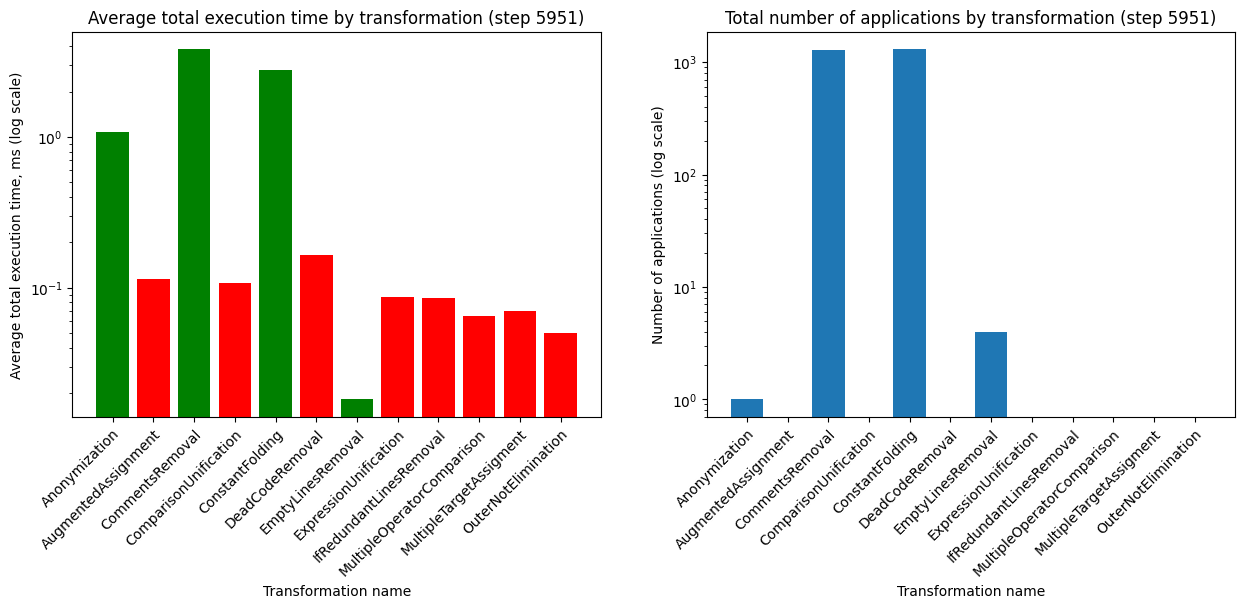

Transformations statistics for step: 7135
Average number of unification iterations: 1.085


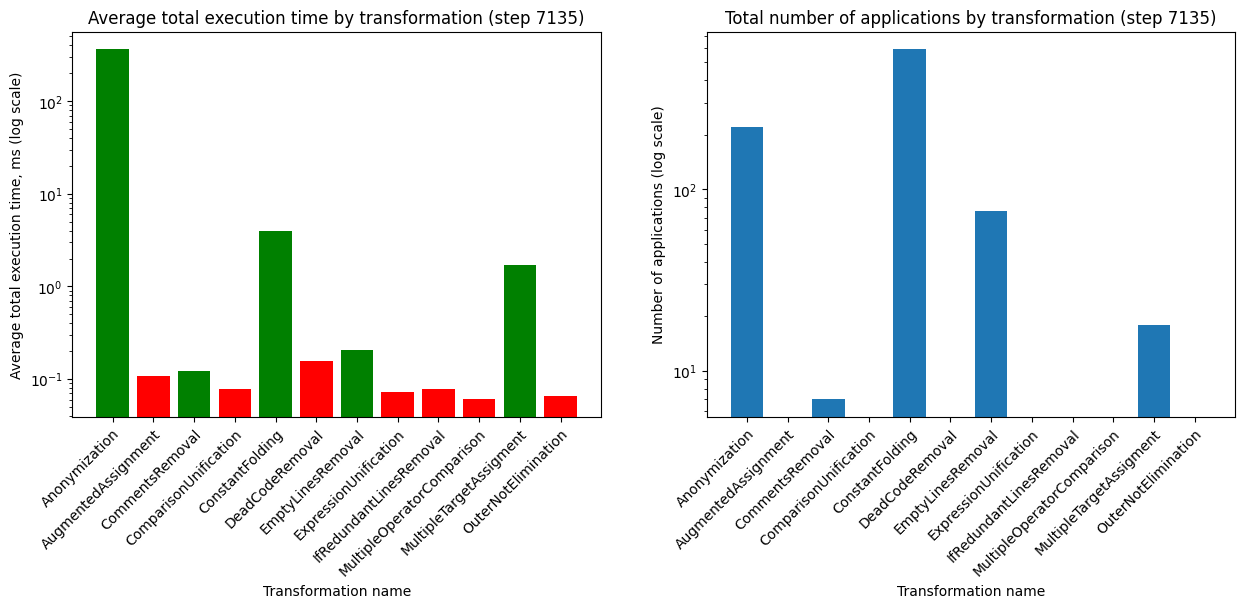

Transformations statistics for step: 8556
Average number of unification iterations: 1.419


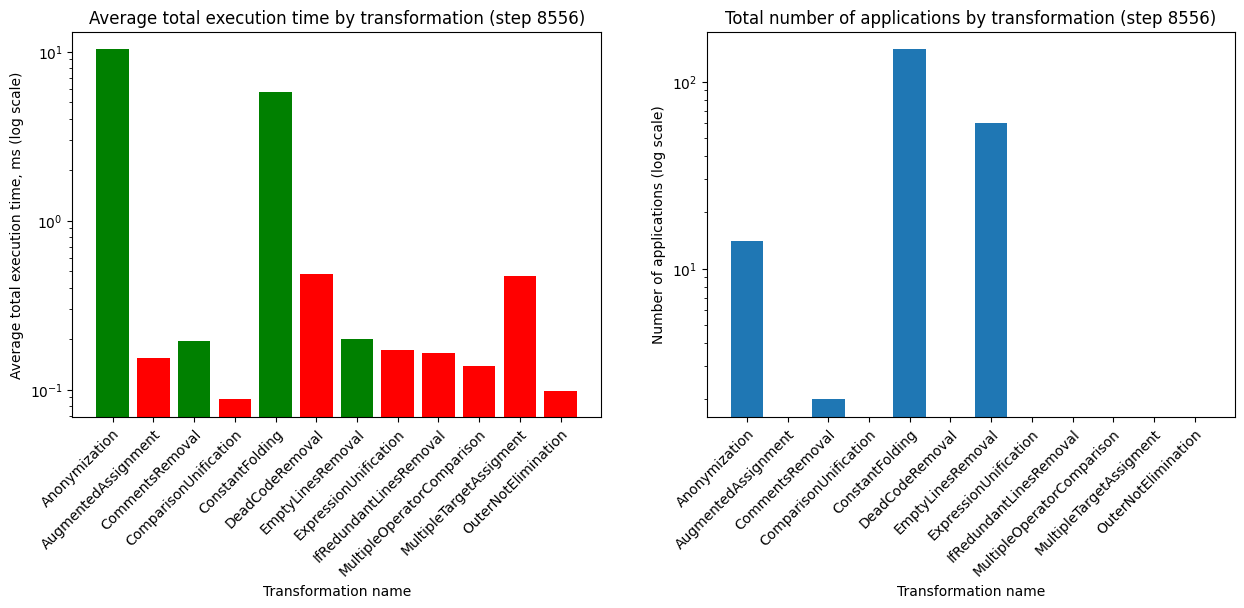

Transformations statistics for step: 10157
Average number of unification iterations: 1.091


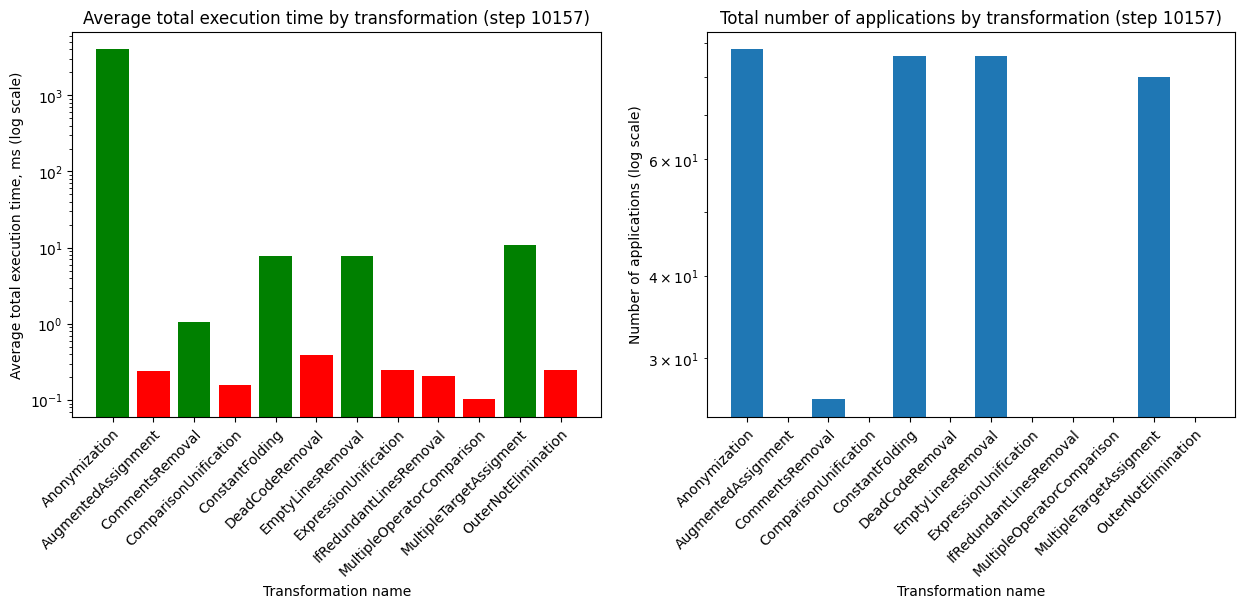

Transformations statistics for step: 11714
Average number of unification iterations: 1.611


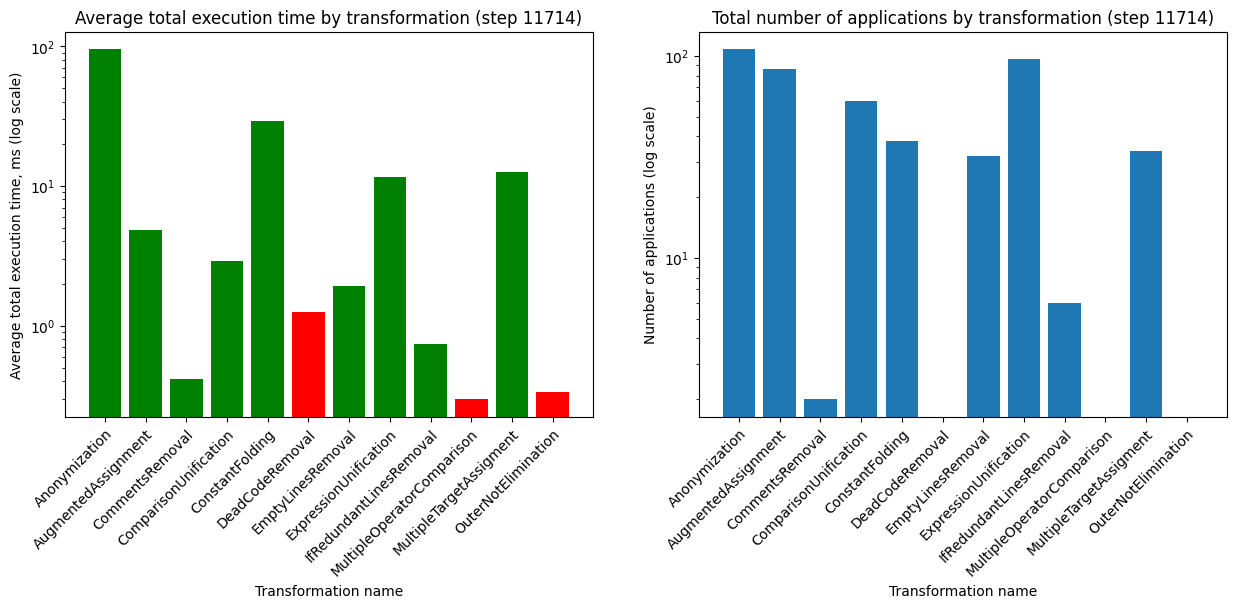

Transformations statistics for step: 12589
Average number of unification iterations: 1.338


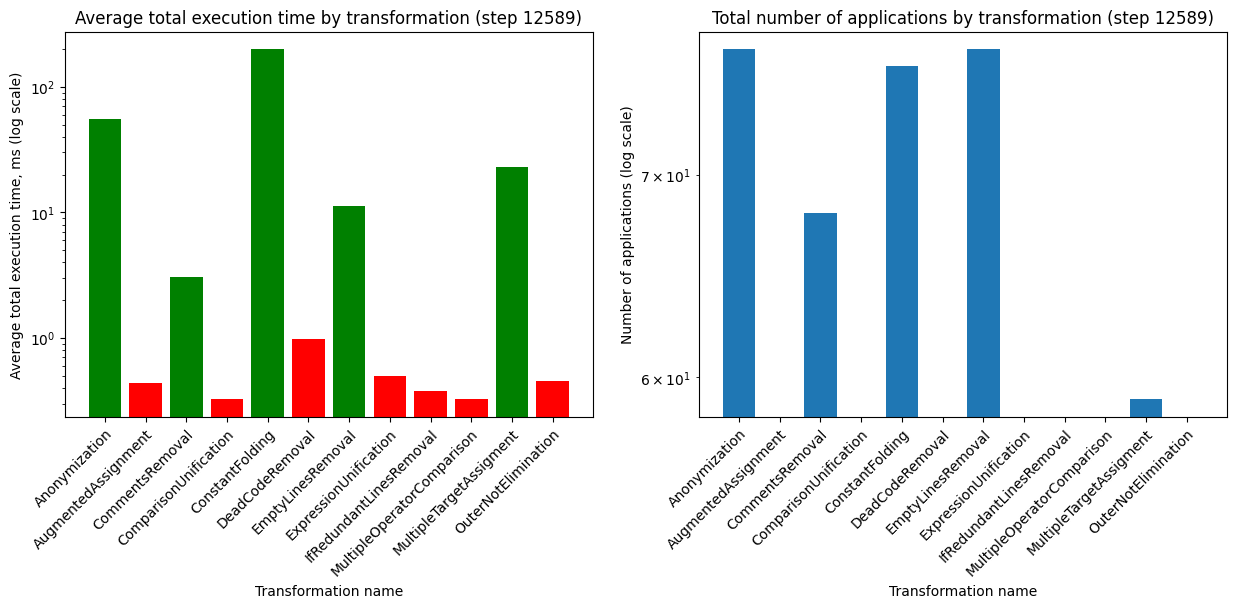

In [7]:
transf_exec_time_total_all_steps = {tr: 0 for tr in transformations}
transf_apl_cnt_total_all_steps = { tr: 0 for tr in transformations }
transf_avg_exec_time_dist = {}
transf_apl_cnt_dist = {}

for step in logs_by_stepid.keys():
    iterations_cnt, transf_exec_time, transf_apl_cnt = parse_logs(logs_by_stepid[step])
    
    disp = step in steps_shortlist
    try:
        if disp:
            print(f'Transformations statistics for step: {step}')
        
        avg_iter = sum(iterations_cnt) / len(iterations_cnt)
        if disp:
            print(f'Average number of unification iterations: {round(avg_iter, 3)}')

            fig, axs = plt.subplots(1,2, figsize=(15,5))
            for ax in axs:
                ax.set_xticks(ticks = range(len(transformations)), labels = transformations)
                ax.set_xticklabels(transformations, rotation=45, rotation_mode='anchor', ha='right')
                ax.set_xlabel('Transformation name')

        avg_transf_exec_time_total = {
            tr: sum([st[tr] for st in transf_exec_time]) / len(transf_exec_time) for tr in transformations 
        }
        total_transf_apl_cnt = { 
            tr: sum([st[tr] for st in transf_apl_cnt]) for tr in transformations 
        }
        colors = ['green' if total_transf_apl_cnt[tr] > 0 else 'red' for tr in avg_transf_exec_time_total.keys()]

        for tr in transformations:
            transf_exec_time_total_all_steps[tr] += sum([st[tr] for st in transf_exec_time])
            transf_apl_cnt_total_all_steps[tr] += total_transf_apl_cnt[tr]
        transf_avg_exec_time_dist[step] = avg_transf_exec_time_total
        transf_apl_cnt_dist[step] = total_transf_apl_cnt

        if disp:
            axs[0].bar(
                avg_transf_exec_time_total.keys(), 
                avg_transf_exec_time_total.values(), 
                color=colors,
                log=True,
            )
            axs[0].set_title(f'Average total execution time by transformation (step {step})')
            axs[0].set_ylabel('Average total execution time, ms (log scale)')

            axs[1].bar(total_transf_apl_cnt.keys(), total_transf_apl_cnt.values(), log=True)
            axs[1].set_title(f'Total number of applications by transformation (step {step})')
            axs[1].set_ylabel('Number of applications (log scale)')

            plt.show()
    except:
        continue

## Overall transformations analysis

The plots below show total execution time and total number of applications for every transformation over all operated steps. The color code is similar to used in the plots above.

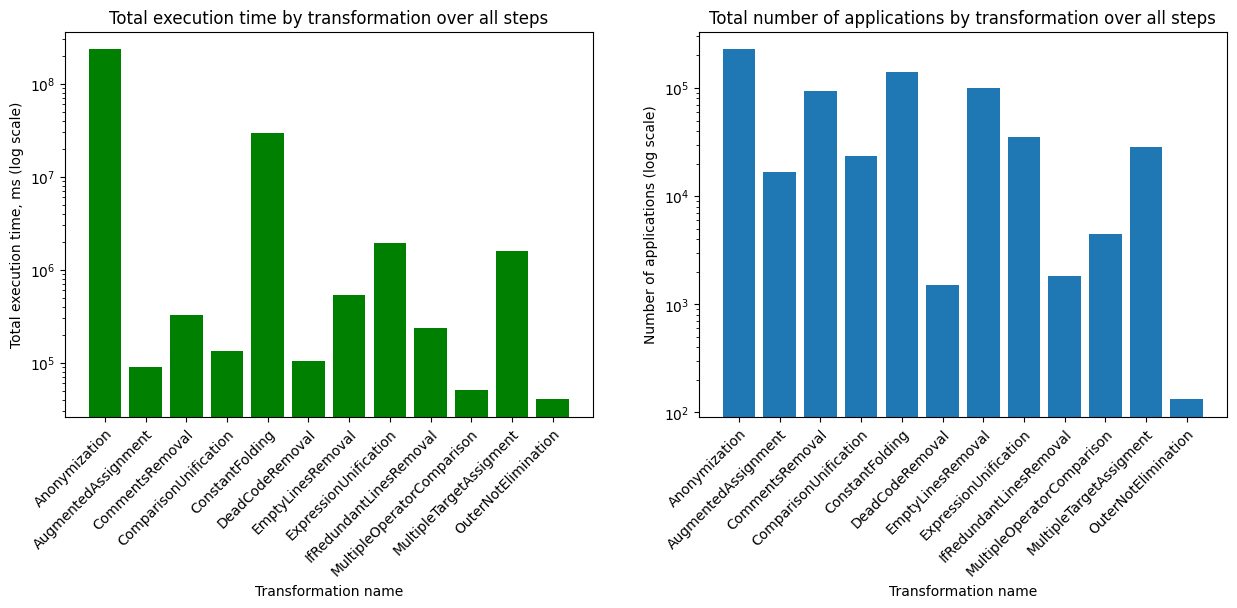

In [8]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
for i in range(2):
    axs[i].set_xticks(ticks = range(len(transformations)), labels = transformations)
    axs[i].set_xticklabels(transformations, rotation=45, rotation_mode='anchor', ha='right')
    axs[i].set_xlabel('Transformation name')
    
colors = ['green' if transf_apl_cnt_total_all_steps[tr] > 0 else 'red' for tr in transformations]

axs[0].bar(
    transf_exec_time_total_all_steps.keys(),
    transf_exec_time_total_all_steps.values(),
    color=colors,
    log=True,
)
axs[0].set_title('Total execution time by transformation over all steps')
axs[0].set_ylabel('Total execution time, ms (log scale)')

axs[1].bar(transf_apl_cnt_total_all_steps.keys(), transf_apl_cnt_total_all_steps.values(), log=True)
axs[1].set_title(f'Total number of applications by transformation over all steps')
axs[1].set_ylabel('Number of applications (log scale)')

plt.show()

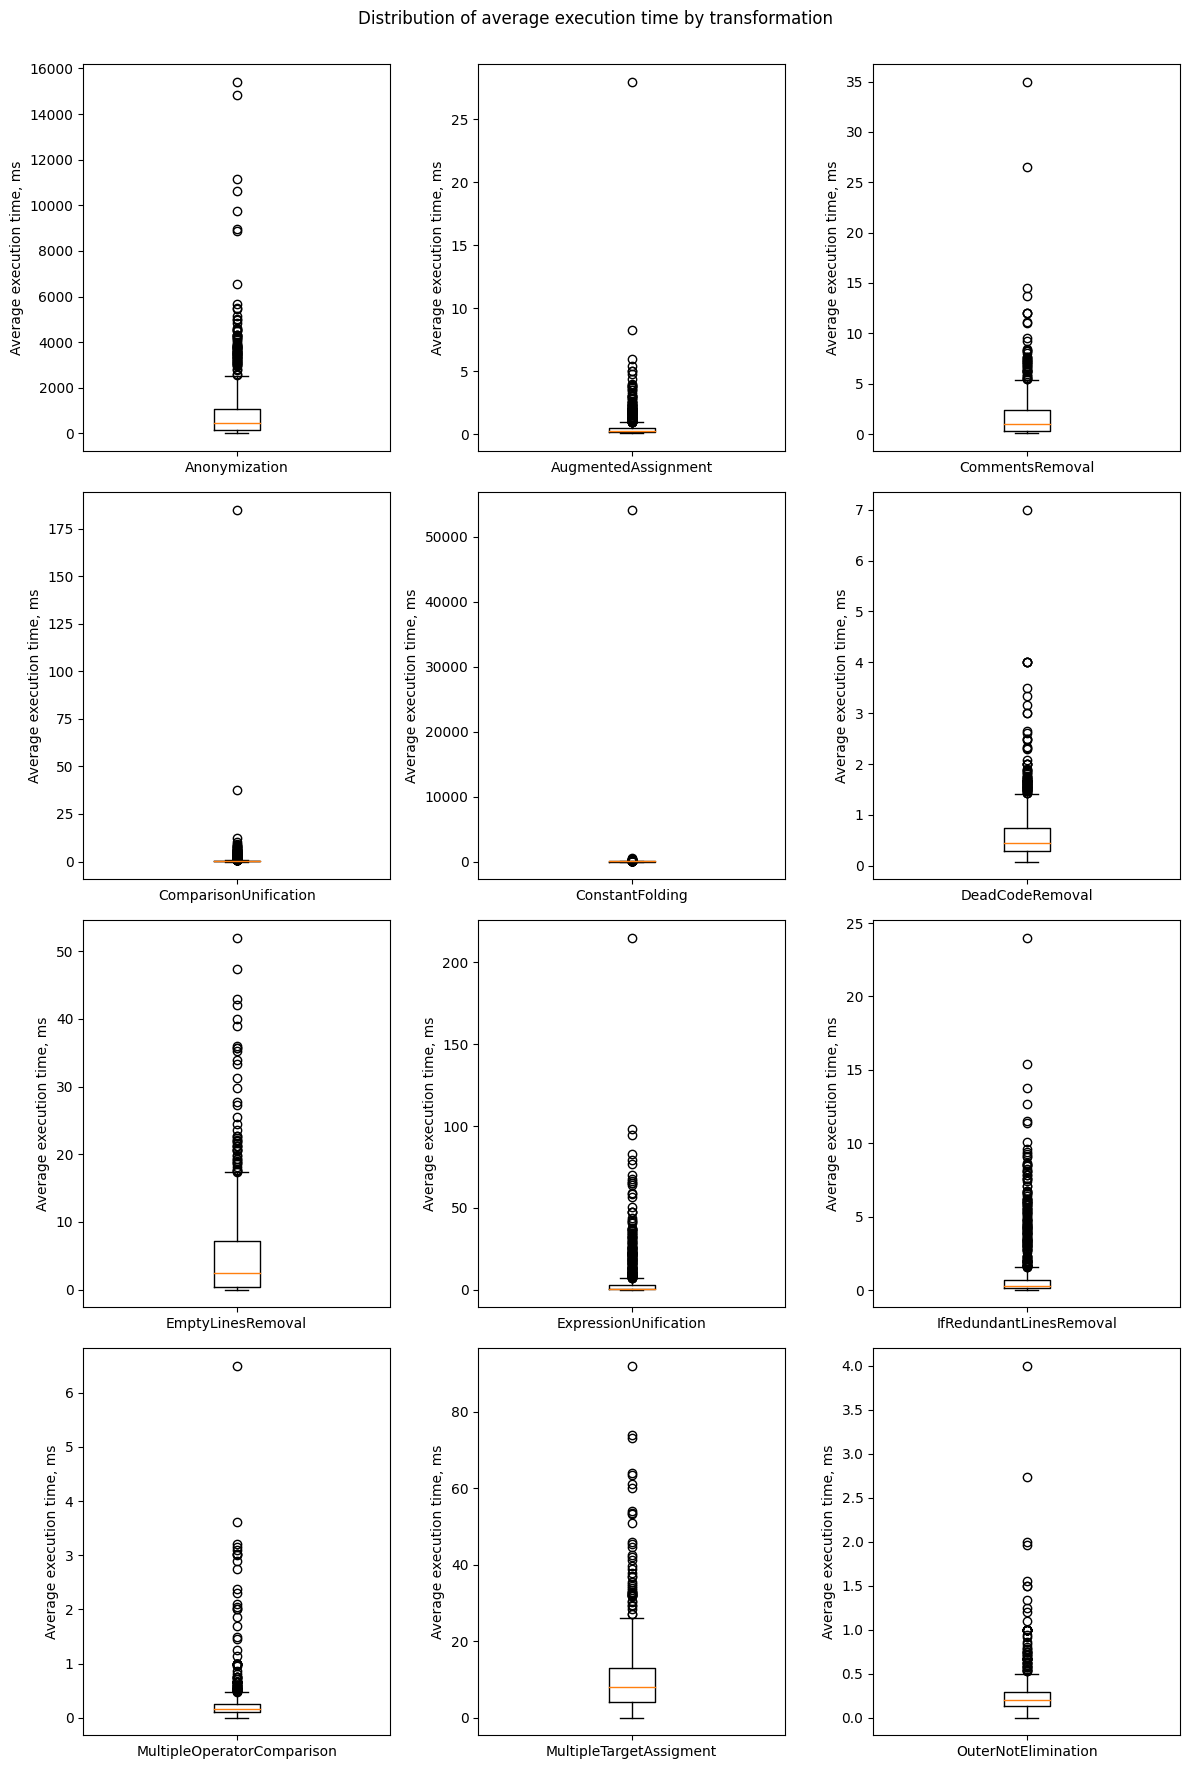

In [9]:
fig, axs = plt.subplots(len(transformations) // 3,3, figsize=(12,18))

fig.suptitle('Distribution of average execution time by transformation')

for i in range(len(transformations)):
    axs[i // 3][i % 3].set_ylabel('Average execution time, ms')
    
for i, tr in enumerate(transformations):
    axs[i // 3][i % 3].boxplot(
        [transf_avg_exec_time_dist[step][tr] for step in transf_avg_exec_time_dist.keys()],
        labels=[tr],
    )

fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

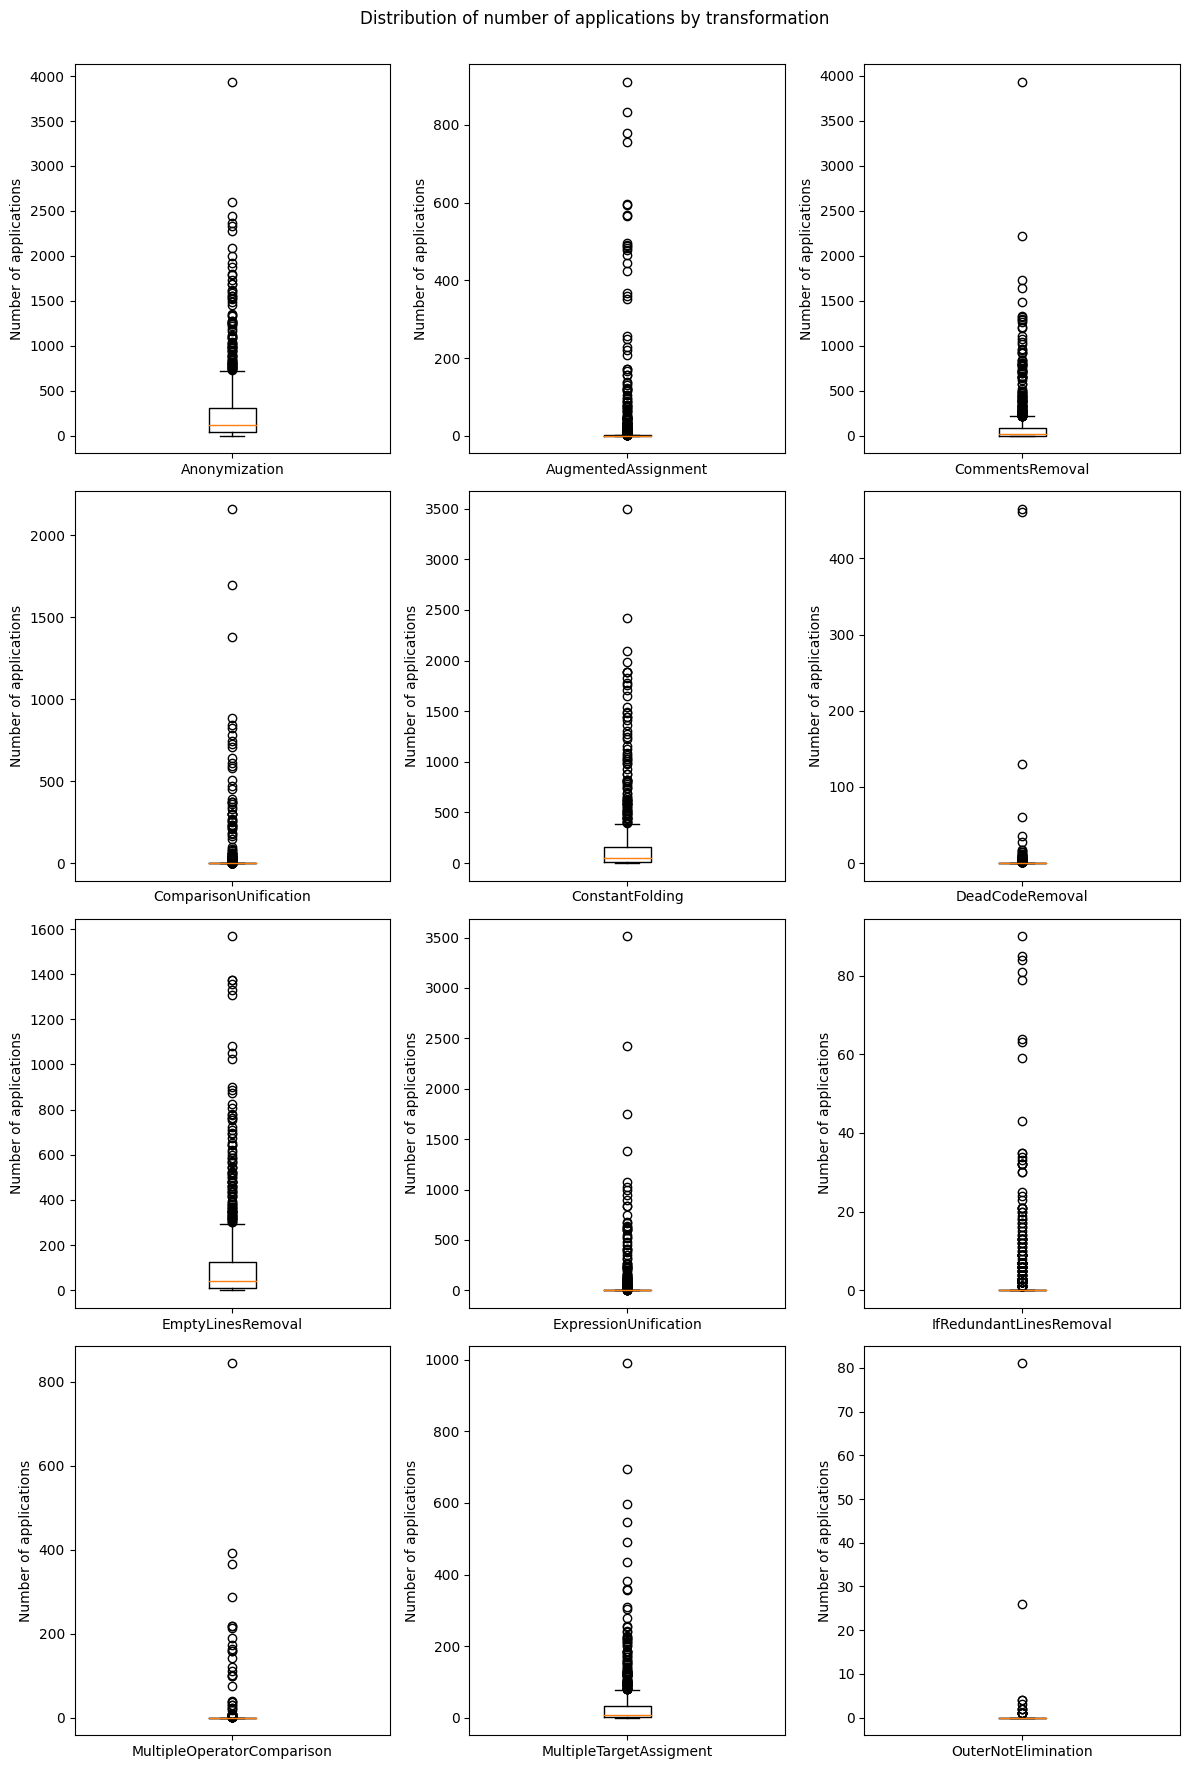

In [10]:
fig, axs = plt.subplots(len(transformations) // 3,3, figsize=(12,18))

fig.suptitle('Distribution of number of applications by transformation')

for i in range(len(transformations)):
    axs[i // 3][i % 3].set_ylabel('Number of applications')
    
for i, tr in enumerate(transformations):
    axs[i // 3][i % 3].boxplot(
        [transf_apl_cnt_dist[step][tr] for step in transf_apl_cnt_dist.keys()],
        labels=[tr],
    )

fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()